In [2]:
%load_ext autoreload
%autoreload 2   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import utils
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np
import heirarchal_clustering
from Levenshtein import ratio, distance
import difflib
import json
import post_clustering

In [43]:
# Loading the original strands

original_strands, original_strand_ids = utils.read_synthesized_strands_from_file(file_path=r"C:\Users\Parv\Doc\RA\Projects\incomplete_cycles\v2\raptor_data\cat.jpg_RU10 2.fasta")

with open('raptor_data.json', 'r') as f:
    read_dict = json.load(f)

reads = read_dict['strands']
ids = read_dict['ids']

In [44]:
# Loading the reads - replaced by json to make it quicker
#reads = utils.postprocess_badread_sequencing_data(fastq_filepath=r"C:\Users\Parv\Doc\RA\Projects\incomplete_cycles\v2\raptor_data\reads.fastq", sample=True)

In [81]:
sampled_reads, sampled_ids = utils.sample_reads(reads, ids, n_samples=15000)

In [82]:
start_adapter = "AATGTACTTCGTTCAGTTACGTATTGCT" 
end_adapter = "GCAATACGTAACTGAACGAAGT"

In [83]:
original_strand_length = len(original_strands[0])
max_length = original_strand_length + len(start_adapter) + len(end_adapter) + 5
min_length = original_strand_length - 5

# Length filtering
sampled_reads_indices = [sampled_reads.index(i) for i in sampled_reads if len(i) < max_length and len(i) > min_length]
sampled_reads = [sampled_reads[i] for i in sampled_reads_indices]
sampled_ids = [sampled_ids[i] for i in sampled_reads_indices]


sampled_reads, sampled_ids = post_clustering.remove_adapters_from_strands(sampled_reads, sampled_ids, original_strand_length=original_strand_length)

Removing adapters


100%|██████████| 14360/14360 [00:00<00:00, 17808.44it/s]


In [84]:
sample_stats = utils.get_sample_statistics(records=sampled_reads, strand_ids=sampled_ids, original_strands=original_strands, original_strand_ids=original_strand_ids, distance_threshold=40, reference=True)

100%|██████████| 14351/14351 [00:00<00:00, 22265.76it/s]


In [85]:
sample_stats

{'distance_threshold': 40,
 'strands_by_index': array([18., 16., 19., ..., 12., 20., 12.]),
 'mean_strands_per_index': 14.233067729083665,
 'std_strands_per_index': 3.6901211598937564,
 'unique_matches': 1004,
 'n_straight': 7143,
 'n_reverse': 7147,
 'unmatched': 60}

In [86]:
cluster_inds, cluster_strands, centroids = heirarchal_clustering.cluster_trivial(sampled_reads, use_centroids=False, distance_threshold=40)

# can also cluster without adapters and do reconstruction with adapters if its better - will have to deal with reverse strands then somehow

Total strands 14351


100%|██████████| 14351/14351 [01:05<00:00, 219.15it/s]

Number of clusters = 1154


In [87]:
# Sorting clusters by length

sort_indices = utils.get_sort_by_sublists_length(cluster_inds)

sorted_clusters = [cluster_inds[i] for i in sort_indices]
sorted_centroids = [centroids[i] for i in sort_indices]
sorted_clustered_seqs = [cluster_strands[i] for i in sort_indices]

centroids = sorted_centroids
clusters = sorted_clusters
clustered_seqs = sorted_clustered_seqs

cluster_lens = [len(i) for i in cluster_inds[:1004]]

In [102]:


def check_clusters(original_strands, clusters, clustered_seqs, make_guess=False):
    """
    Given the cluster indices, returns the traceback recoveries (checks for reversals)
    """

    edit_distances = []
    recs = []
    guesses = []
    for ind, cluster in enumerate(tqdm(clusters)):
        strand_id = sampled_ids[cluster[0]]
        
        if strand_id == 'junk_seq' or strand_id == 'random_seq':
            continue
        
        original_strand_index = original_strand_ids.index(strand_id)
        reference = original_strands[original_strand_index]
        cluster_head = clustered_seqs[ind][0]

        if make_guess:
            guess_sequences = clustered_seqs[ind]
            guess = heirarchal_clustering.make_prediction(guess_sequences, min(15, len(guess_sequences)))
            cluster_head = guess

        rec_1 = ratio(reference, cluster_head)
        rec_2 = ratio(reference, utils.reverse_complement(cluster_head))

        if rec_1 > rec_2:
            guesses.append(cluster_head)
            recs.append(utils.get_recovery_percentage(cluster_head, reference))
        else:
            guesses.append(utils.reverse_complement(cluster_head))
            recs.append(utils.get_recovery_percentage(utils.reverse_complement(cluster_head), reference))
        
        edit_distances.append(max([rec_1, rec_2]))


    return recs, edit_distances, guesses


    

In [89]:
def checking_incorrect_strands_within_cluster(clusters, sampled_ids):
    unique_strand_ids_per_cluster = []
    for i in clusters[:1004]:
        unique_strand_ids = set()
        for j in i:
            strand_id = sampled_ids[j]
            unique_strand_ids.add(strand_id)

        unique_strand_ids_per_cluster.append(list(unique_strand_ids))
    print(sum([1 for i in unique_strand_ids_per_cluster if len(i)>1]))


    

In [104]:
# without guesses
recs_1, edit_distances_1, guesses_1= check_clusters(original_strands, clusters[:1004], clustered_seqs, make_guess=False)

  0%|          | 0/1004 [00:00<?, ?it/s]

(array([  4.,   8.,  14.,  13.,  38.,  71., 105., 223., 380., 148.]),
 array([0.90025575, 0.9099808 , 0.91970585, 0.9294309 , 0.93915595,
        0.94888099, 0.95860604, 0.96833109, 0.97805614, 0.98778119,
        0.99750623]),
 <BarContainer object of 10 artists>)

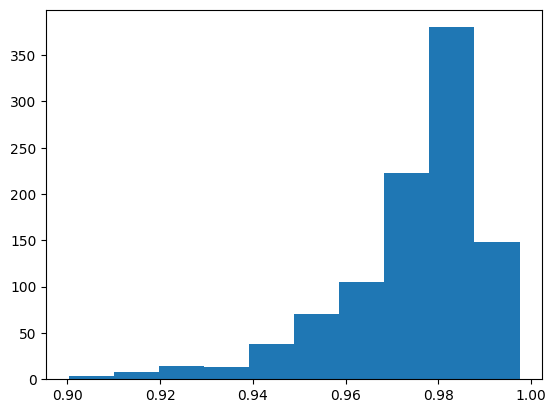

In [105]:
plt.hist(edit_distances_1)

In [109]:
recs_2, edit_distances_2, guesses_2 = check_clusters(original_strands, clusters[:1004], clustered_seqs, make_guess=True)

  0%|          | 0/1004 [00:00<?, ?it/s]

(array([ 86., 113.,   2.,   1.,   3.,   1.,   0.,   2.,   1., 795.]),
 array([0.16 , 0.244, 0.328, 0.412, 0.496, 0.58 , 0.664, 0.748, 0.832,
        0.916, 1.   ]),
 <BarContainer object of 10 artists>)

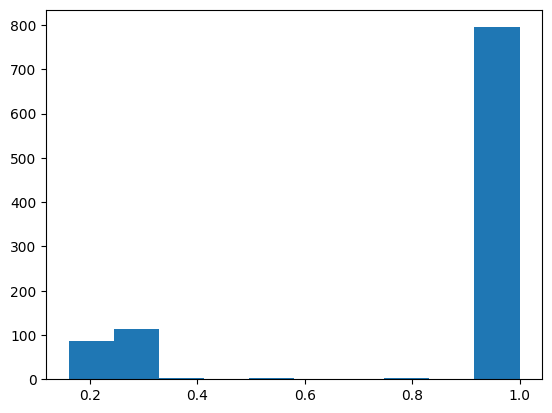

In [110]:
plt.hist(recs_2)

In [124]:
guesses_fixed = []

for i in guesses_2:
    updated_guess = i
    t = 0
    if len(i) > 200:
        t = len(i) - 200
        updated_guess = updated_guess[t:]
    elif len(i) < 200:
        updated_guess = utils.create_random_strand(200 - len(i))+ updated_guess

    guesses_fixed.append(updated_guess)

In [126]:
# checking alignment of guesses

recs = []

for cluster, guess in zip(clusters, guesses_fixed):
    strand_id = sampled_ids[cluster[0]]
    
    if strand_id == 'junk_seq' or strand_id == 'random_seq':
        continue
    
    original_strand_index = original_strand_ids.index(strand_id)
    reference = original_strands[original_strand_index]

    cluster_head = guess
    print(len(cluster_head))
    print(len(cluster))
    print(ratio(cluster_head, reference))
    print(utils.get_recovery_percentage(cluster_head, reference))

    rec = utils.get_recovery_percentage(cluster_head, reference)
    recs.append(rec)
    
    if not rec == 1.0:
        print(utils.align(cluster_head, reference, identity=False))
    
    print()

    

200
28
1.0
1.0

200
27
1.0
1.0

200
26
1.0
1.0

200
24
1.0
1.0

200
24
1.0
1.0

200
24
1.0
1.0

200
24
1.0
1.0

200
23
1.0
1.0

200
23
1.0
1.0

200
23
1.0
1.0

200
23
0.995
0.26
target            0 TCCCATAAGCGCCAATCGGTTGCATACATGTCAAACTAAGACGCGCCTCTCCAAGTCCAG
                  0 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
query             1 TCCCATAAGCGCCAATCGGTTGCATACATGTCAAACTAAGACGCGCCTCTCCAAGTCCAG

target           60 TATGACAGCCTGTTCCGTCTGTCCCAACATGGCCAAAGCTTCACTCGCCTCCTGATAATG
                 60 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
query            61 TATGACAGCCTGTTCCGTCTGTCCCAACATGGCCAAAGCTTCACTCGCCTCCTGATAATG

target          120 TTGGTAAAACGTGGCAAGCAATTGTGGCCATTAATGCGACCCGTGACCATTAGAGTTCCG
                120 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
query           121 TTGGTAAAACGTGGCAAGCAATTGTGGCCATTAATGCGACCCGTGACCATTAGAGTTCCG

target          180 CGGACCATTATGTGATTGT 199
                180 ||||||||||||||||||| 199
qu

In [128]:
import uuid

guess_ids = [str(uuid.uuid4()) for i in range(len(original_strands))]
utils.create_fasta_file(guess_ids, guesses_fixed, output_filepath='raptor_data/guesses.fasta')

In [98]:
clusters_by_index = np.zeros(len(original_strands))

for i in clusters[:1004]:
    try:
        clusters_by_index[original_strand_ids.index(sampled_ids[i[0]])] += 1
    except:
        continue

print("Number of repeated cluster heads")
print(sum([1 for i in clusters_by_index if i > 1]))

print("Average strands in top n clusters")
print(np.mean(cluster_lens))

print("Min strands in top n clusters")
print(np.min(cluster_lens))

Number of repeated cluster heads
1
Average strands in top n clusters
14.116533864541832
Min strands in top n clusters
5


In [173]:


def get_best_candidates_and_recoveries(original_strands, candidates):
    """
    For a given set of strands, finds the best candidates and returns a dictionary with
    the recoveries, the number of fully recovered strands, the best set of candidates and the
    original strands
    """
    
    fully_recovered_strands = 0
    recoveries = []
    partially_recovered_recoveries = []
    best_candidates = []

    for strand in tqdm(original_strands):
        if strand in candidates:
            fully_recovered_strands += 1
            recoveries.append(1.0)
            best_candidates.append(strand)
        else:
            best_recovery_within_candidates = 0.0
            best_candidate = ""
            for candidate in candidates:
                rev_candidate = utils.reverse_complement(candidate)
                strand_recovery = ratio(candidate, strand)

                if strand_recovery > best_recovery_within_candidates:
                    best_recovery_within_candidates = strand_recovery
                    best_candidate = candidate

                strand_recovery = ratio(rev_candidate, strand)

                if strand_recovery > best_recovery_within_candidates:
                    best_recovery_within_candidates = strand_recovery
                    best_candidate = candidate

            recoveries.append(best_recovery_within_candidates)
            partially_recovered_recoveries.append(best_recovery_within_candidates)
            best_candidates.append(best_candidate)

    return {
        "recoveries": recoveries,
        "fully_recovered_strands": fully_recovered_strands,
        "partially_recovered_recoveries": partially_recovered_recoveries,
        "best_candidates": best_candidates,
        "original_strands": original_strands
    }


def check_clusters(original_strands, original_strand_ids, strand_ids, cluster_inds, centroids):

    recoveries = []
    for ind, i in enumerate(cluster_inds):
        cluster_strand_id = strand_ids[i[0]]

        if cluster_strand_id == 'random_seq' or cluster_strand_id == 'junk_seq':
            continue
        
        rat1 = ratio(centroids[ind], original_strands[original_strand_ids.index(cluster_strand_id)])
        print(rat1)
        rat2 = ratio(utils.reverse_complement(centroids[ind]), original_strands[original_strand_ids.index(cluster_strand_id)])
        print(rat2)
        print()

        recoveries.append(max(rat1, rat2))
        

    return recoveries


In [174]:
recs = check_clusters(original_strands, original_strand_ids, sampled_ids, clusters, centroids)

0.631578947368421
0.9674185463659148

0.9824561403508771
0.6566416040100251

0.985
0.625

0.605
0.645

0.63
0.63

0.625
0.64

0.63
0.955

0.985
0.675

0.62
0.9299999999999999

0.9776674937965261
0.6501240694789081

0.625
0.985

0.91
0.63

0.645
0.975

0.635
0.6699999999999999

0.62
0.635

0.6466165413533835
0.6466165413533835

0.6566416040100251
0.9724310776942355

0.9624060150375939
0.6566416040100251

0.965
0.6599999999999999

0.64
0.98

0.65
0.98

0.6065162907268171
0.9924812030075187

0.655
0.99

0.98
0.64

0.64
0.94

0.65
0.99

0.985
0.665

0.987468671679198
0.7017543859649122

0.6566416040100251
0.9774436090225564

0.9824561403508771
0.6566416040100251

0.6234413965087282
0.9875311720698254

0.6466165413533835
0.9824561403508771

0.985
0.645

0.6416040100250626
0.9774436090225564

0.625
0.97

0.6416040100250626
0.9573934837092732

0.645
0.945

0.6451612903225806
0.9727047146401985

0.975
0.645

0.96
0.6599999999999999

0.645
0.985

0.6517412935323383
0.9800995024875622

0.6516290

(array([  1.,   0.,   0.,   2.,  88., 703.,  10.,  49.,  90., 249.]),
 array([0.26086957, 0.33428261, 0.40769565, 0.4811087 , 0.55452174,
        0.62793478, 0.70134783, 0.77476087, 0.84817391, 0.92158696,
        0.995     ]),
 <BarContainer object of 10 artists>)

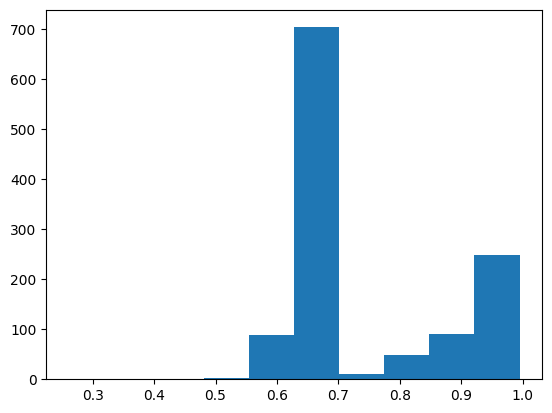

In [175]:
plt.hist(recs)

In [161]:
recs = get_best_candidates_and_recoveries(original_strands, centroids[:1004])

  0%|          | 0/1004 [00:00<?, ?it/s]

(array([  3.,   0.,   0.,   0.,   0.,   0.,   2.,  31., 137., 831.]),
 array([0.68      , 0.71174937, 0.74349875, 0.77524812, 0.80699749,
        0.83874687, 0.87049624, 0.90224561, 0.93399499, 0.96574436,
        0.99749373]),
 <BarContainer object of 10 artists>)

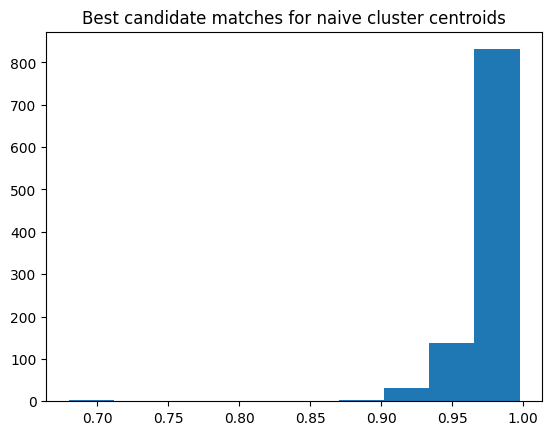

In [164]:
plt.title("Best candidate matches for naive cluster centroids")
plt.hist(recs['recoveries'])

(0.0, 1.0)

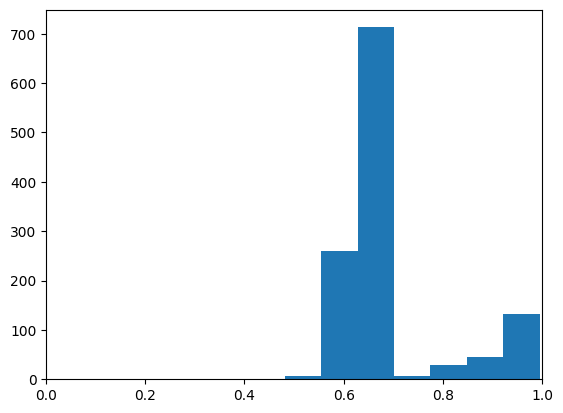

In [155]:
plt.hist(recs)
plt.xlim(0, 1)

In [ ]:
recs2 = get_best_candidates_and_recoveries(original_strands, clus)

In [60]:
centroid_indices = [i[0] for i in cluster_inds]
centroid_records = [sampled[j] for j in centroid_indices][:1004]

centroid_stats = utils.get_sample_statistics(records = centroid_records, original_strands=original_strands, original_strand_ids=ids, reference=True, distance_threshold=40)

100%|██████████| 1004/1004 [00:00<00:00, 24248.58it/s]


In [61]:
centroid_stats

{'distance_threshold': 40,
 'strands_by_index': array([1., 1., 1., ..., 1., 1., 1.]),
 'mean_strands_per_index': 0.9800796812749004,
 'std_strands_per_index': 0.3860123979098825,
 'unique_matches': 919,
 'n_straight': 444,
 'n_reverse': 540,
 'unmatched': 20}

In [101]:
# Pick a cluster and reconstruct that strand
for i in clusters:
    strands = [sampled_reads[j] for j in i]
    strand_id = sampled_ids[i[0]]
    original_strand_index = original_strand_ids.index(strand_id)

    for j in strands:
        print(ratio(j, original_strands[original_strand_index]))
        print(ratio(utils.reverse_complement(j), original_strands[original_strand_index]))
        print()

0.6616541353383458
0.987468671679198

0.6765432098765432
0.962962962962963

0.6616541353383458
0.987468671679198

0.9797979797979798
0.6666666666666667

0.658354114713217
0.9925187032418953

0.99
0.6599999999999999

0.655
0.96

0.9355608591885441
0.6587112171837709

0.6699266503667481
0.9682151589242054

0.6600985221674878
0.9261083743842364

0.9848484848484849
0.6565656565656566

0.9776674937965261
0.6550868486352357

0.6602409638554216
0.9542168674698795

0.6616541353383458
0.9924812030075187

0.655
0.98

0.9800995024875622
0.6567164179104478

0.6616161616161615
0.9797979797979798

0.982367758186398
0.6599496221662469

0.6433915211970075
0.9775561097256857

0.9875311720698254
0.658354114713217

0.6599999999999999
0.99

0.6599999999999999
0.985

0.982367758186398
0.6599496221662469

0.6632911392405063
0.9417721518987342

0.6650485436893203
0.9466019417475728

0.9801980198019802
0.6584158415841583

0.6599999999999999
0.985

0.9849246231155779
0.6633165829145728

0.9875311720698254
0.62

ValueError: 'random_seq' is not in list